In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches
from scarches.models import TRANVAE
from scarches.dataset import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.set_figure_params(dpi=100)

In [4]:
dir_path = os.path.expanduser(f'~/Documents/tranvae/panc_ood_2/')
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
save_path = os.path.expanduser(f'~/Documents/tranvae/panc_ood_2/revision/')
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [5]:
adata_ref = sc.read(f'{dir_path}reference_data.h5ad')
ref_batches = adata_ref.obs['batch'].unique().tolist()
ref_batches = ref_batches[0:3]
ref_ct_all = adata_ref.obs['celltype'].unique().tolist()
ref_ct = ref_ct_all[1:8]
ref_lndmk = ref_ct_all[8:]
ref_ct_orig = adata_ref.obs['celltype_orig'].unique().tolist()
ref_ct_orig = ref_ct_orig[:7]

ref_batches.sort()
ref_ct.sort()
ref_lndmk.sort()
ref_ct_orig.sort()

print(ref_batches)
print(ref_ct)
print(ref_lndmk)
print(ref_ct_orig)

['Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas inDrop']
['Pancreas Acinar', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Ductal', 'Pancreas Endothelial', 'Pancreas Gamma', 'Pancreas Stellate']
['Landmark Pancreas Acinar', 'Landmark Pancreas Beta', 'Landmark Pancreas Delta', 'Landmark Pancreas Ductal', 'Landmark Pancreas Endothelial', 'Landmark Pancreas Gamma', 'Landmark Pancreas Stellate', 'Landmark unlabeled']
['Pancreas Acinar', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Ductal', 'Pancreas Endothelial', 'Pancreas Gamma', 'Pancreas Stellate']


In [17]:
adata_full = sc.read(f'{dir_path}full_data.h5ad')
adata_full.obs.batch = adata_full.obs.batch.replace('Pancreas CelSeq2', 'Pancreas CelSeq2 (query)')
adata_full.obs.batch = adata_full.obs.batch.replace('Pancreas SS2', 'Pancreas SS2 (query)')
adata_full.obs.celltype = adata_full.obs.celltype.replace('Pancreas Alpha', 'Pancreas Alpha (NEW)')
adata_full.obs.celltype = adata_full.obs.celltype.replace('Landmark Pancreas Alpha', 'Landmark Pancreas Alpha (NEW)')
adata_full.obs.celltype_orig = adata_full.obs.celltype_orig.replace('Pancreas Alpha', 'Pancreas Alpha (NEW)')
adata_full.obs.prediction = adata_full.obs.prediction.replace('Pancreas Alpha', 'Pancreas Alpha (NEW)')
f_batches = adata_full.obs['batch'].unique().tolist()
f_batches = f_batches[0:5]
f_ct_all = adata_full.obs['celltype'].unique().tolist()
f_ct = f_ct_all[1:9]
f_lndmk = f_ct_all[9:]
f_ct_orig = adata_full.obs['celltype_orig'].unique().tolist()
f_ct_orig = f_ct_orig[:8]

f_batches.sort()
f_ct.sort()
f_lndmk.sort()
f_ct_orig.sort()

print(f_batches)
print(f_ct)
print(f_lndmk)
print(f_ct_orig)

['Pancreas CelSeq', 'Pancreas CelSeq2 (query)', 'Pancreas Fluidigm C1', 'Pancreas SS2 (query)', 'Pancreas inDrop']
['Pancreas Acinar', 'Pancreas Alpha (NEW)', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Ductal', 'Pancreas Endothelial', 'Pancreas Gamma', 'Pancreas Stellate']
['Landmark Pancreas Acinar', 'Landmark Pancreas Alpha (NEW)', 'Landmark Pancreas Beta', 'Landmark Pancreas Delta', 'Landmark Pancreas Ductal', 'Landmark Pancreas Endothelial', 'Landmark Pancreas Gamma', 'Landmark Pancreas Stellate', 'Landmark unlabeled']
['Pancreas Acinar', 'Pancreas Alpha (NEW)', 'Pancreas Beta', 'Pancreas Delta', 'Pancreas Ductal', 'Pancreas Endothelial', 'Pancreas Gamma', 'Pancreas Stellate']


In [7]:
b_c = sc.pl.palettes.godsnot_102[10:16] + ['red']
batch_color = [b_c[5], b_c[6], b_c[2], b_c[3], b_c[0]]
ct_c = sc.pl.palettes.godsnot_102
#ct_color = [ct_c[0], ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],ct_c[7],ct_c[1],'black',ct_c[0], ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],ct_c[7],ct_c[1],'black']
ct_color = [ct_c[0], ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],ct_c[7],'black',ct_c[0], ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],ct_c[7],'black']

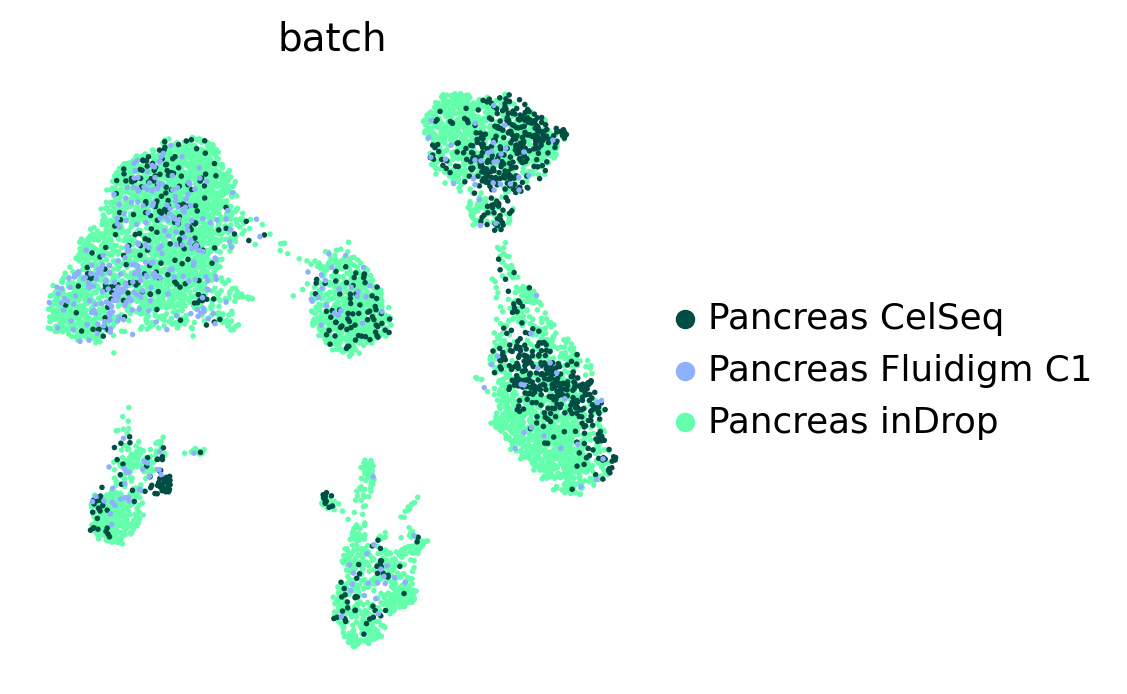

In [8]:
sc.pl.umap(adata_ref,
           color=['batch'],
           frameon=False,
           groups=ref_batches,
           wspace=0.6,
           show=False,
           palette=batch_color,
           )
plt.savefig(f"{save_path}r_batch.pdf", bbox_inches='tight')

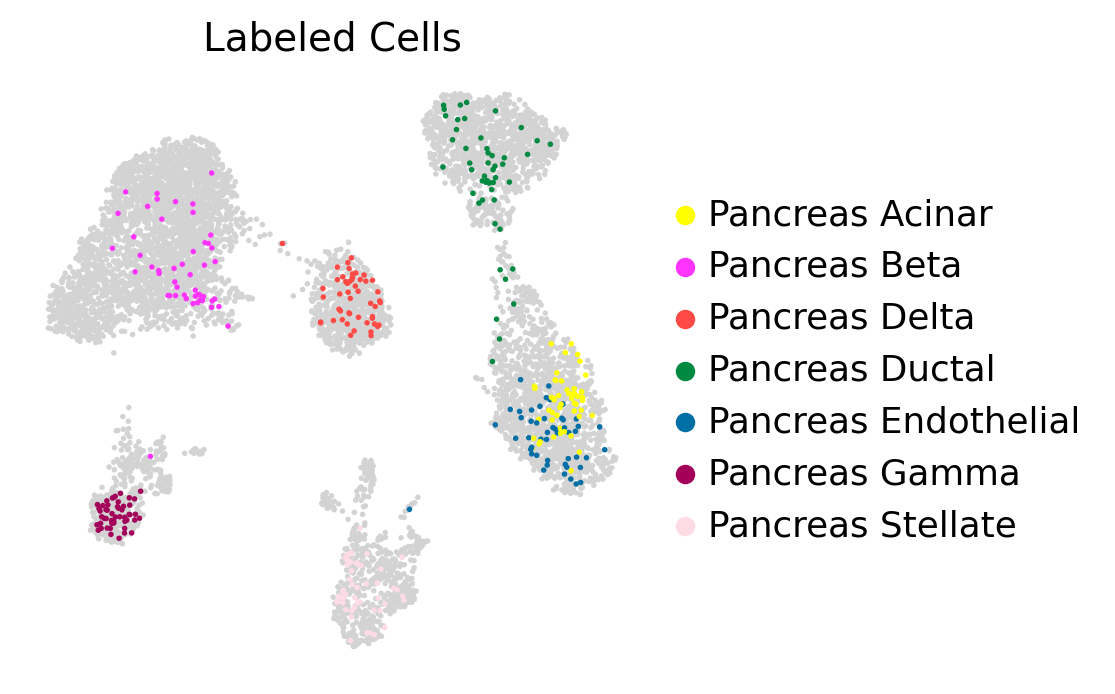

In [9]:
sc.pl.umap(adata_ref,
           title='Labeled Cells',
           color=['celltype'],
           frameon=False,
           groups=ref_ct,
           wspace=0.6,
           show=False,
           palette=ct_color
          )
plt.savefig(f"{save_path}r_ct_labeled.pdf", bbox_inches='tight')

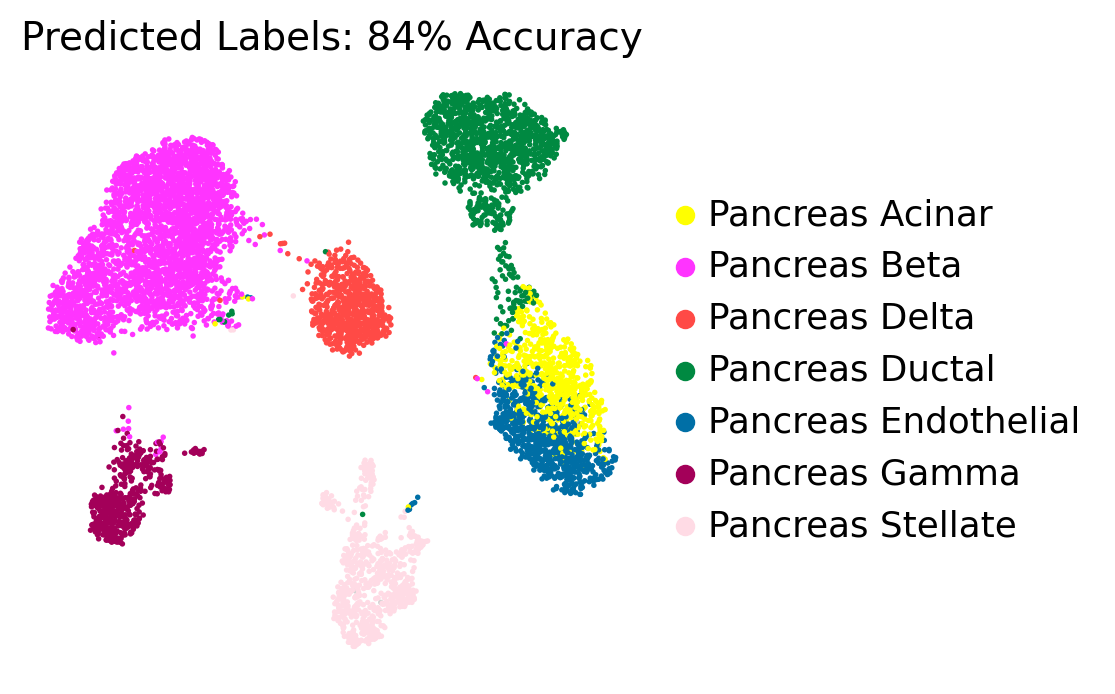

In [10]:
sc.pl.umap(adata_ref,
           title='Predicted Labels: 84% Accuracy',
           color=['prediction'],
           frameon=False,
           groups=ref_ct,
           wspace=0.6,
           show=False,
           palette=ct_color
          )
plt.savefig(f"{save_path}r_ct_pred.pdf", bbox_inches='tight')

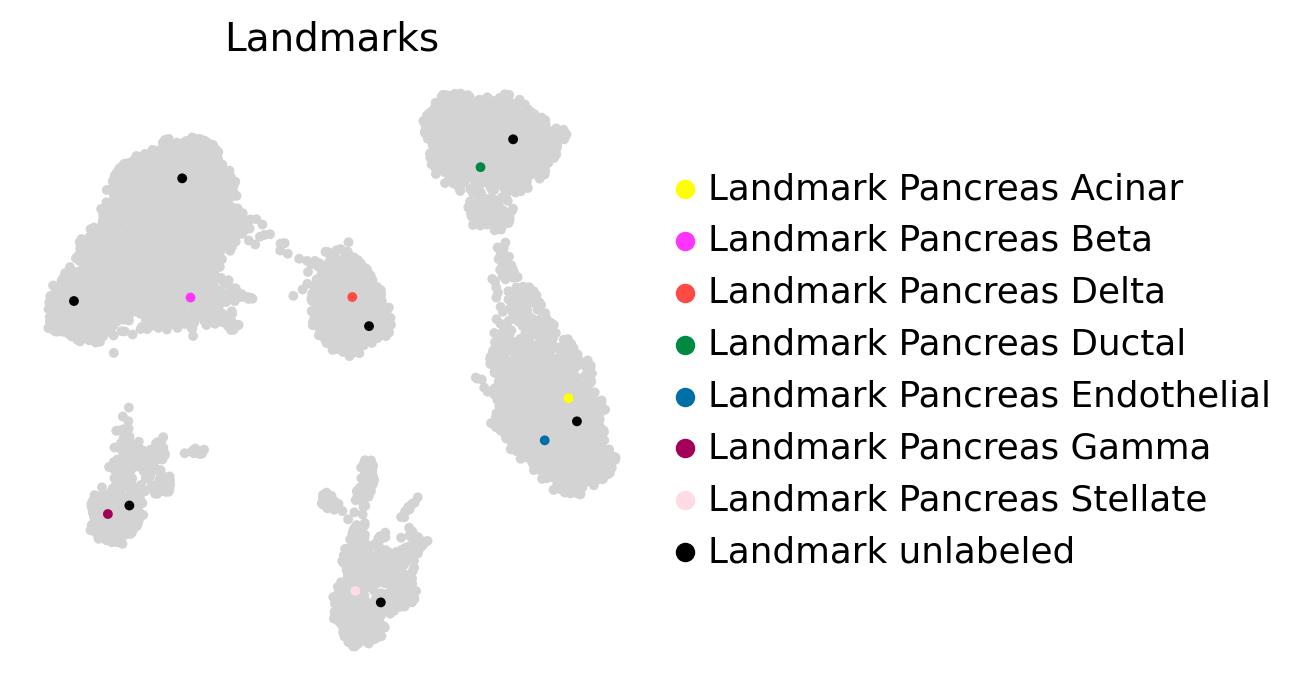

In [11]:
sc.pl.umap(adata_ref,
           title='Landmarks',
           color=['celltype'],
           frameon=False,
           groups=ref_lndmk,
           wspace=0.6,
           show=False,
           palette=ct_color,
           size=50
          )
plt.savefig(f"{save_path}r_ct_landmark.pdf", bbox_inches='tight')

In [12]:
f_bc = [b_c[5], b_c[6], b_c[2], b_c[1], b_c[3],b_c[4],b_c[0]]

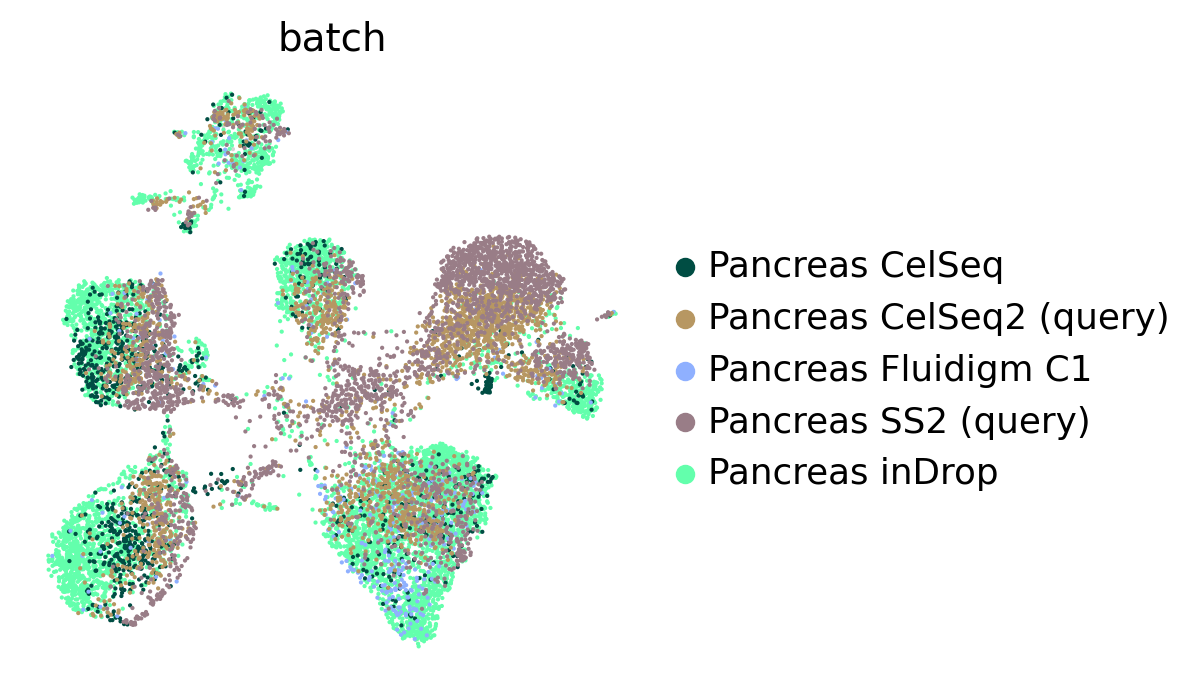

In [13]:
sc.pl.umap(adata_full,
           color=['batch'],
           frameon=False,
           groups=f_batches,
           wspace=0.6,
           show=False,
           palette=f_bc,
           )
plt.savefig(f"{save_path}f_batch.pdf", bbox_inches='tight')

In [14]:
f_ctc = [ct_c[0],ct_c[1], ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],ct_c[7],'black',ct_c[0], ct_c[1], ct_c[2],ct_c[3],ct_c[4],ct_c[5],ct_c[6],ct_c[7], 'black']

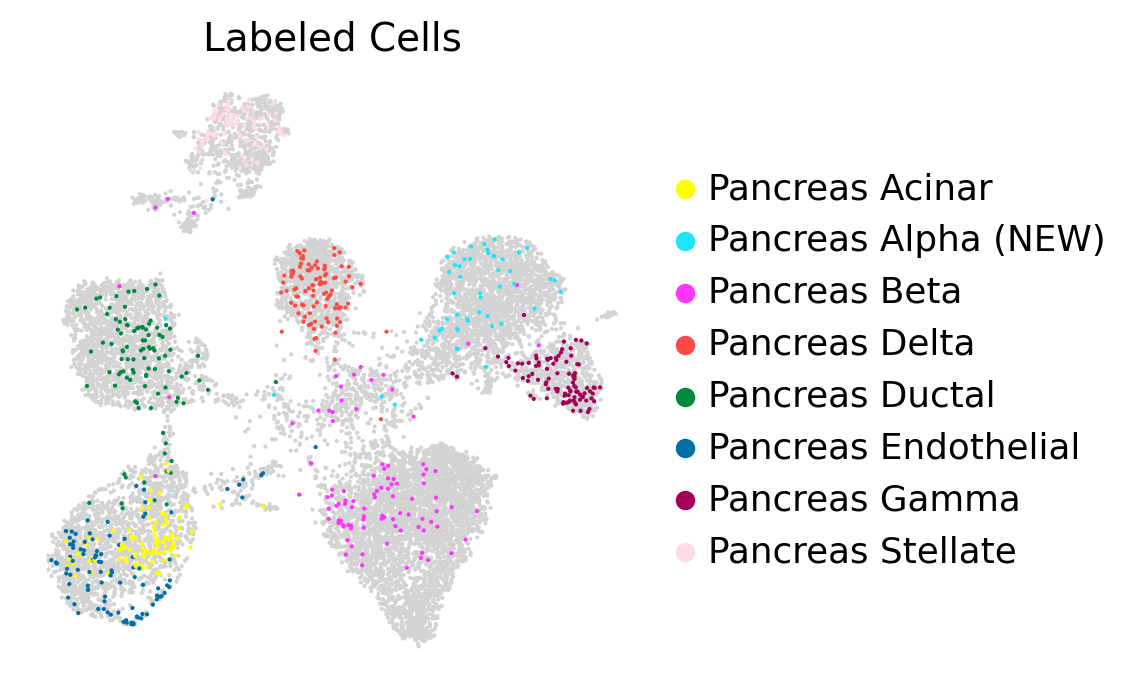

In [15]:
sc.pl.umap(adata_full,
           title='Labeled Cells',
           color=['celltype'],
           frameon=False,
           groups=f_ct,
           wspace=0.6,
           show=False,
           palette=f_ctc
          )
plt.savefig(f"{save_path}f_ct_labeled.pdf", bbox_inches='tight')

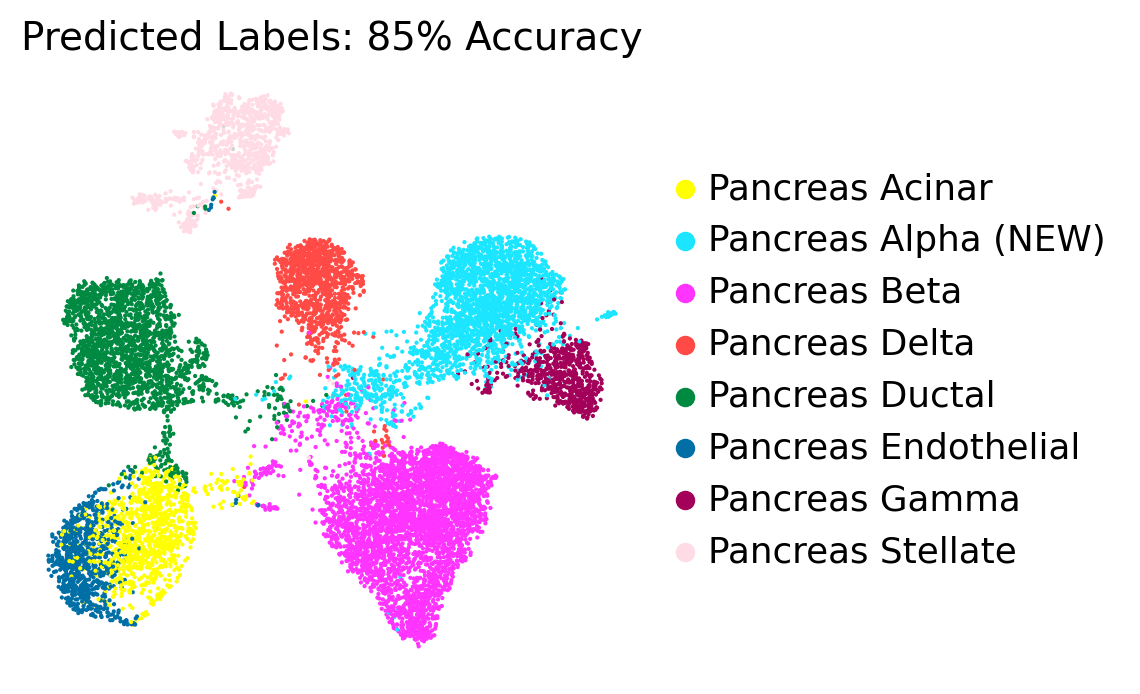

In [18]:
sc.pl.umap(adata_full,
           title='Predicted Labels: 85% Accuracy',
           color=['prediction'],
           frameon=False,
           groups=f_ct,
           wspace=0.6,
           show=False,
           palette=f_ctc
          )
plt.savefig(f"{save_path}f_ct_pred.pdf", bbox_inches='tight')

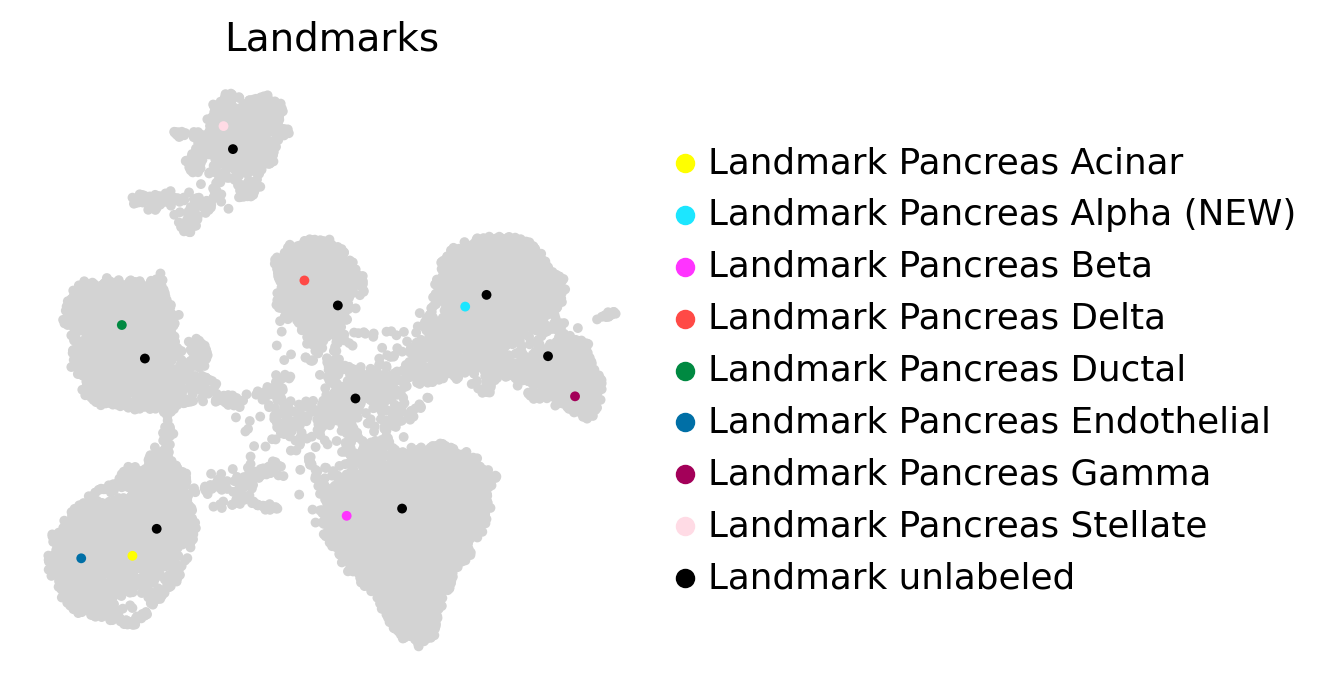

In [19]:
sc.pl.umap(adata_full,
           title='Landmarks',
           color=['celltype'],
           frameon=False,
           groups=f_lndmk,
           wspace=0.6,
           show=False,
           palette=f_ctc,
           size=50
          )
plt.savefig(f"{save_path}f_ct_landmark.pdf", bbox_inches='tight')